In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

In [30]:
B0 = 10  # Z direction, Tesla
rho = 1e6
U0 = 1. 
L = 10.  # Length of domain in 
a = 10.  # Length of domain in Z direction
b = 20.  # Length of domain in Y direction
nu = 1.  
eta = 1. 
Ha = L * B0 * np.sqrt(1/(rho * nu * eta))
print('Hartmann number = ', Ha)
chi = b / a
def lamda(n):
    return n * np.pi / (2 * chi)
def kappa(n):
    return 2 * np.sin(lamda(n) * chi) / (lamda(n) * chi)
def p1(n):
    return 0.5 * (Ha - np.sqrt(Ha ** 2 + 4 * lamda(n) ** 2))
def p2(n):
    return 0.5 * (Ha + np.sqrt(Ha ** 2 + 4 * lamda(n) ** 2))
def un(n, z):
    return (kappa(n) / lamda(n) ** 2) * (1 - (np.sinh(p2(n)) * np.cosh(p1(n) * z) - np.sinh(p1(n)) * np.cosh(p2(n) * z))/ np.sinh(p2(n) - p1(n)))
def bn(n, z):
    return (kappa(n) / lamda(n) ** 2) * (np.sinh(p1(n)) * np.sinh(p2(n) * z) - np.sinh(p2(n)) * np.sinh(p1(n) * z))/ np.sinh(p2(n) - p1(n))
def u(y, z, n_trunc):
    u_sum = np.zeros((len(y), len(z)))
    for i in range(n_trunc):
        if i % 2 != 0:
            for j in range(len(y)):
                u_sum[j, :] += un(i, z) * np.cos(lamda(i) * y[j])
    return u_sum
def b(y, z, n_trunc):
    b_sum = np.zeros((len(y), len(z)))
    for i in range(n_trunc):
        if i % 2 != 0:
            for j in range(len(y)):
                b_sum[j, :] += bn(i, z) * np.cos(lamda(i) * y[j])
    return b_sum

Hartmann number =  0.1


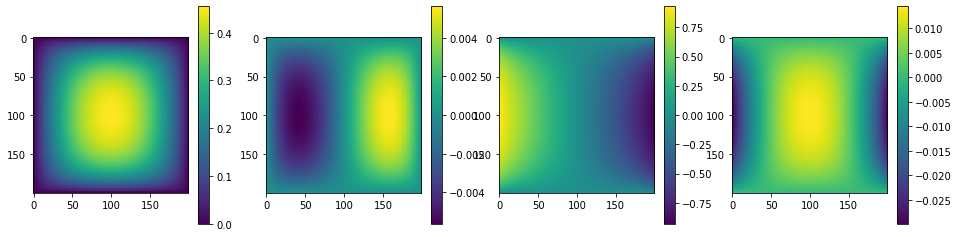

In [31]:
N = 100
y = np.linspace(-chi, chi, 200)
z = np.linspace(-1, 1, 200)
uyz = u(y, z, N)
byz = b(y, z, N)

# Compute u_t from generated solution
t = np.linspace(1, 2, 10)
dz = z[1] - z[0]
u_sol = np.zeros((len(y), len(z), len(t), 2))
uz_sol = np.zeros((len(y), len(z), len(t), 2))
for i in range(len(t)):
    u_sol[:, :, i, 0] = uyz
    u_sol[:, :, i, 1] = byz
for i in range(len(y)):
    for j in range(len(t)):
        uz_sol[i, :, j, :] = ps.FiniteDifference()._differentiate(u_sol[i, :, j, :], dz)

plt.figure(figsize=(16,4))
plt.subplot(1, 4, 1)
plt.imshow(u_sol[:, :, 0, 0])
plt.colorbar()
plt.subplot(1, 4, 2)
plt.imshow(u_sol[:, :, 0, 1])
plt.colorbar()
plt.subplot(1, 4, 3)
plt.imshow(uz_sol[:, :, 0, 0])
plt.colorbar()
plt.subplot(1, 4, 4)
plt.imshow(uz_sol[:, :, 0, 1])
plt.colorbar()

In [32]:
# Choose 80 % of data for training
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u_sol[:, :, train, :]
u_test = u_sol[:, :, test, :]
ut_train = uz_sol[:, :, train, :]
ut_test = uz_sol[:, :, test, :]
t_train = t[train]
t_test = t[test]
Y, Z = np.meshgrid(y, z, indexing='ij')
spatial_grid = np.transpose(np.asarray([Y, Z]), [1, 2, 0])
print(np.shape(spatial_grid))
N = len(y) * len(z)

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (N * len(t_train), 2))
ut_train_flattened = np.reshape(ut_train, (N * len(t_train), 2))
u_test_flattened = np.reshape(u_test, (N * len(t_test), 2))
ut_test_flattened = np.reshape(ut_test, (N * len(t_test), 2))

(200, 200, 2)


In [33]:
# quadratic polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid, include_bias=True, is_uniform=True)
pde_lib.fit(u_train_flattened)
n_features = pde_lib.n_output_features_
constraint_rhs = np.zeros(4)
constraint_lhs = np.zeros((4, 2 * n_features))

# # div(u) = 0 and div(b) = 0 in both equations
# constraint_lhs[0, 6] = 1
# constraint_lhs[0, 8] = 1
# constraint_lhs[1, 7] = 1
# constraint_lhs[1, 9] = 1
# constraint_lhs[2, 6 + n_features] = 1
# constraint_lhs[2, 8 + n_features] = 1
# constraint_lhs[3, 7 + n_features] = 1
# constraint_lhs[3, 9 + n_features] = 1

optimizer = ps.ConstrainedSR3(threshold=0.1, 
                              #constraint_lhs=constraint_lhs,
                              #constraint_rhs=constraint_rhs, 
                              normalize_columns=True, 
                              thresholder='l0', max_iter=50)
                              # constraint_order='feature')
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
uz_constrainedSR3 = model.predict(u_test_flattened)

/Users/alankaptanoglu/pysindy/pysindy/optimizers/constrained_sr3.py:382: ConvergenceWarning: SR3._reduce did not converge after 50 iterations.
  ConvergenceWarning,


In [34]:
model.print(precision=5)
print(n_features)

x0' = 1.00000 x0_2
x1' = 1.00000 x1_2
66


In [23]:
model.get_feature_names()
print(len(model.get_feature_names()))

66


In [7]:
from matplotlib import animation

# make the animation
fps = 30
fig = plt.figure(1, figsize=(20, 6) )
# plot DNS 
clim = [-3, 3]
tbegin = 0
tend = len(t_test)
ut_stlsq = np.reshape(ut_stlsq, (n, n, len(t_test), 2))
ut_sr3 = np.reshape(ut_sr3, (n, n, len(t_test), 2))
ut_constrained_sr3 = np.reshape(ut_constrained_sr3, (n, n, len(t_test), 2))
ut_frols = np.reshape(ut_frols, (n, n, len(t_test), 2))
ut_list = [ut_stlsq, ut_sr3, ut_constrained_sr3, ut_frols]
method_list = ['STLSQ', 'SR3', 'ConstrainedSR3', 'FROLS']
for i, ut_choice in enumerate(ut_list):
    plt.subplot(1, 4, i + 1)
    if i == 0:
        im1 = plt.imshow(ut_choice[:, :, tbegin, 0], cmap='RdBu', origin='lower', 
                        interpolation='gaussian', aspect='auto')
    if i == 1:
        im2 = plt.imshow(ut_choice[:, :, tbegin, 0], cmap='RdBu', origin='lower', 
                        interpolation='gaussian', aspect='auto')
    if i == 2:
        im3 = plt.imshow(ut_choice[:, :, tbegin, 0], cmap='RdBu', origin='lower', 
                        interpolation='gaussian', aspect='auto')
    if i == 3:
        im4 = plt.imshow(ut_choice[:, :, tbegin, 0], cmap='RdBu', origin='lower', 
                        interpolation='gaussian', aspect='auto')
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(method_list[i], fontsize=20)

# animation function for looping through frames
def animate_func(i):
    plt.suptitle('t = {0:.2f}'.format(t[i]), fontsize=20)
    im1.set_array(ut_stlsq[:, :, i, 0])
    im2.set_array(ut_sr3[:, :, i, 0])
    im3.set_array(ut_constrained_sr3[:, :, i, 0])
    im4.set_array(ut_frols[:, :, i, 0])
    return [im1, im2, im3, im4]


anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames = np.arange(tbegin, tend, 1),
                               interval = 200)
anim.save('reaction-diffusion.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
plt.savefig('reaction-diffusion_results.pdf')

NameError: name 'ut_stlsq' is not defined

<Figure size 1440x432 with 0 Axes>

In [ ]:
# Show boosting functionality with 2D PDEs
optimizer = ps.STLSQ(threshold=40, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

model.fit(u_train_flattened, x_dot=ut_train_flattened, ensemble=True, n_models=10, n_subset=len(t_train) // 2)
xticknames = model.get_feature_names()
num_ticks = len(xticknames)

# Plot boosting results with error bars
mean_coefs = np.mean(model.coef_list, axis=0)
std_coefs = np.std(model.coef_list, axis=0)
colors = ['b', 'r', 'k']
feature_names = ['u', 'v']
plt.figure(figsize=(10, 4))
for i in range(mean_coefs.shape[0]):
    plt.errorbar(range(mean_coefs.shape[1]), mean_coefs[i, :], yerr=std_coefs[i, :], 
                 fmt='o', color=colors[i], label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
ax = plt.gca()
ax.set_xticks(range(num_ticks))
for i in range(num_ticks):
    xticknames[i] = '$' + xticknames[i] + '$'
ax.set_xticklabels([])  # xticknames, verticalalignment='top')
plt.legend(fontsize=16, framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.savefig('ensemble_performance.pdf')